In [1]:
import util

ds = util.get_dataset()
train_storms,valid_storms,test_storms= util.train_validation_test(ds,seed=42)

In [31]:
np.isnan(ds.usa_wind.loc[train_storms])

<xarray.DataArray 'usa_wind' (storm: 2188, date_time: 360)>
array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])
Coordinates:
    time     (storm, date_time) datetime64[ns] 1998-10-09T12:00:00.000040448 ...
    lat      (storm, date_time) float32 13.1 13.05 13.1 13.32 ... nan nan nan
    lon      (storm, date_time) float32 -92.5 -92.94 -93.3 ... nan nan nan
  * storm    (storm) |S13 b'1998283N13268' b'1981207S12087' ... b'1987093N05155'
Dimensions without coordinates: date_time
Attributes:
    long_name:              Maximum sustained wind speed
    standard_name:          tropical_cyclone_maximum_sustained_wind_speed
    units:                  kts
    valid_min:              1
    valid_max:              250
    coverage_content_type:  physicalMeasurement

In [2]:
import numpy as np

def make_X_y(ds,idx,timesteps=5):
    X_out = []
    Y_out = []
    for s in idx:
        usa_pres = ds.usa_pres.loc[s]
        usa_wind = ds.usa_wind.loc[s]
        valid_coords = ~(np.isnan(usa_wind) | np.isnan(usa_pres))
        lat = ds.lat.loc[s][valid_coords]
        lon = ds.lon.loc[s][valid_coords]
        usa_pres = usa_pres[valid_coords]
        usa_wind = usa_wind[valid_coords]
        #dist2land = ds.dist2land.loc[s][valid_coords]

        X = np.transpose(np.array([usa_wind,usa_pres,lat,lon]))
        for i in range(0,len(usa_wind)):
            if i+timesteps+1 >= len(usa_wind) :
                break
            X_out.append(X[i:i+timesteps])
            Y_out.append(X[i+timesteps+1])

    X_out = np.array(X_out)
    Y_out = np.array(Y_out) 
    return X_out,Y_out

## flatten for basic models

In [3]:
TIMEPOINTS = 15

In [4]:
x_train,y_train = make_X_y(ds,train_storms,TIMEPOINTS)
x_train_flt = x_train.reshape((-1,TIMEPOINTS*4))

In [5]:
x_train.shape

(55868, 15, 4)

## Random Forest

In [6]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100)

In [7]:
rf.fit(x_train_flt,y_train)

RandomForestRegressor()

In [8]:
valid_x,valid_y = make_X_y(ds,valid_storms,TIMEPOINTS)

In [9]:
valid_x_flt = valid_x.reshape((-1,4*TIMEPOINTS))

In [10]:
pred_y = rf.predict(valid_x_flt)

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
valid_y_norm= scaler.fit_transform(valid_y)
pred_y_norm= scaler.transform(pred_y)

In [12]:
rmse = np.sqrt(np.mean( (pred_y_norm - valid_y_norm)**2))

In [13]:
rmse

0.15173021102329512

In [107]:
from sklearn.metrics import mean_squared_error
mean_squared_error(valid_y,pred_y,multioutput='raw_values',squared=False)

array([5.37647187, 4.51742966, 2.00930057, 2.12558606])

### does this even work?

In [19]:
def recursive_predict(initial_x,model,size):
    y = np.zeros((size,4))
    y[:TIMEPOINTS] = initial_x[:]
    x = initial_x
    for step in range(size-TIMEPOINTS):
        output = model.predict(x.reshape(1,4*TIMEPOINTS))
        y[TIMEPOINTS+step] = output[0]
        x = np.roll(x,-1,axis=0)
        x[-1] = output
    return y

In [20]:
STORM = 20

In [21]:
valid_wind_profile = ds.usa_wind.loc[valid_storms[STORM]]
valid_pressure_profile = ds.usa_pres.loc[valid_storms[STORM]]
valid_wind_profile = valid_wind_profile[~np.isnan(valid_wind_profile)].to_numpy()
valid_pressure_profile = valid_pressure_profile[~np.isnan(valid_pressure_profile)].to_numpy()
valid_lat = ds.lat.loc[valid_storms[STORM]].to_numpy()
valid_lon = ds.lon.loc[valid_storms[STORM]].to_numpy()

size = len(valid_wind_profile)

In [22]:
x_valid_i,_ = make_X_y(ds,[valid_storms[STORM]],timesteps=TIMEPOINTS)

In [23]:
ypred_full = recursive_predict(x_valid_i[0],rf,size)

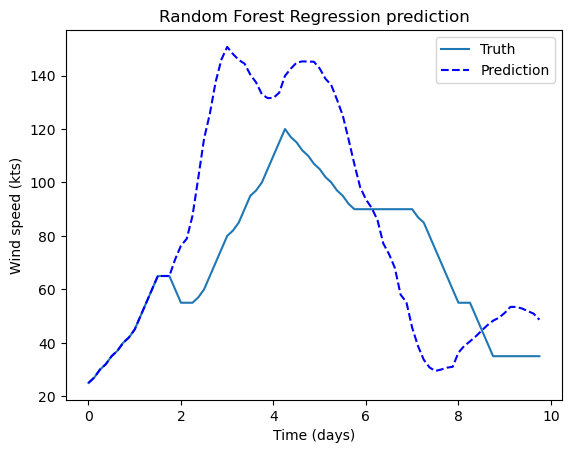

In [24]:
import matplotlib.pyplot as plt
t = np.arange(0,len(valid_wind_profile)/8,1/8)
plt.plot(t,valid_wind_profile,label="Truth")
plt.plot(t,ypred_full[:,0],'b--',label="Prediction")
plt.xlabel("Time (days)")
plt.ylabel("Wind speed (kts)")
plt.title("Random Forest Regression prediction")
plt.legend()

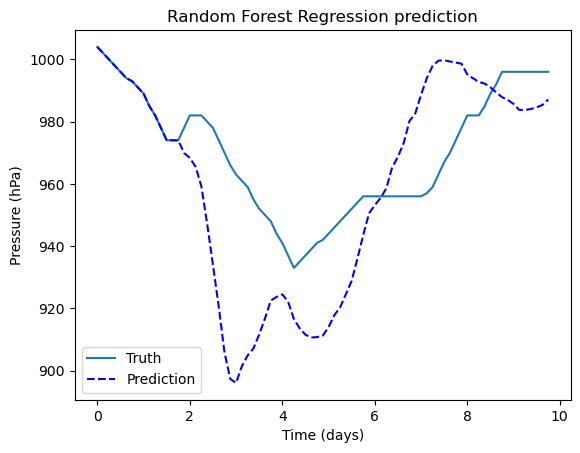

In [25]:
plt.plot(t,valid_pressure_profile,label="Truth")
plt.plot(t,ypred_full[:,1],'b--',label="Prediction")
plt.xlabel("Time (days)")
plt.ylabel("Pressure (hPa)")
plt.title("Random Forest Regression prediction")
plt.legend()

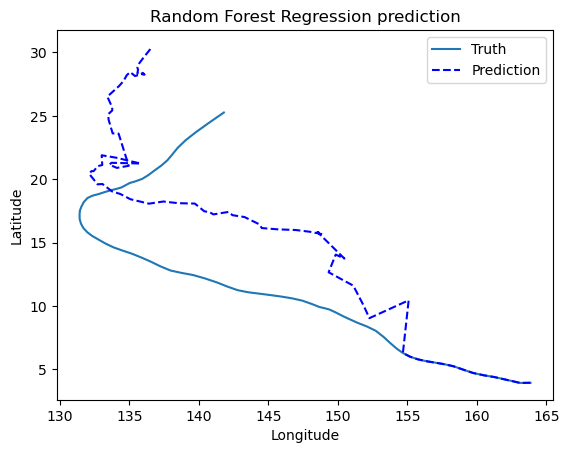

In [26]:
plt.plot(valid_lon[:size],valid_lat[:size],label="Truth")
plt.plot(ypred_full[:,3],ypred_full[:,2],'b--',label="Prediction")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Random Forest Regression prediction")
plt.legend()

### Mean profile

In [52]:
### this is not very efficent but who cares
usa_pres = ds.usa_pres.loc[valid_storms,:TIMEPOINTS]
usa_wind = ds.usa_wind.loc[valid_storms,:TIMEPOINTS]
selected_storms = ~(np.isnan(usa_pres) | np.isnan(usa_wind)).any(axis=-1)
lat = ds.lat.loc[valid_storms,:TIMEPOINTS][selected_storms]
lon = ds.lon.loc[valid_storms,:TIMEPOINTS][selected_storms]
usa_pres = usa_pres[selected_storms]
usa_wind = usa_wind[selected_storms]


In [95]:
RUNTO = 300

x_valid_start = np.transpose(np.array([usa_wind,usa_pres,lat,lon]),axes=(1,2,0))
y = np.zeros((x_valid_start.shape[0],RUNTO,x_valid_start.shape[2]))
y[:,:TIMEPOINTS] = x_valid_start

for step in range(RUNTO-TIMEPOINTS):
    y[:,step+TIMEPOINTS] = rf.predict(y[:,step:step+TIMEPOINTS].reshape(-1,(4*TIMEPOINTS)))


In [99]:
median_profile = np.median(y,axis=0)
tenth_percentile = np.percentile(y,q=5,axis=0)
nintith_percentile= np.percentile(y,q=95,axis=0)

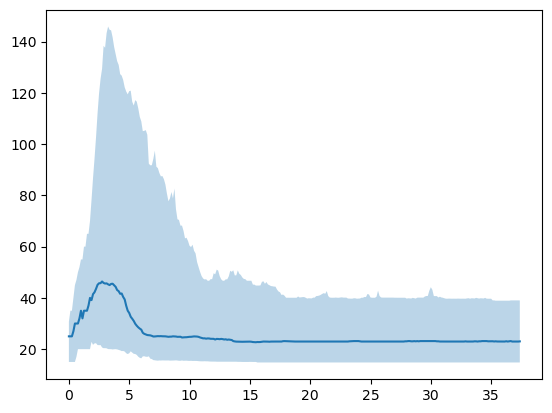

In [100]:
plt.plot(np.arange(RUNTO)/8,median_profile[:,0])
plt.fill_between(np.arange(RUNTO)/8,tenth_percentile[:,0],nintith_percentile[:,0],alpha=0.3)

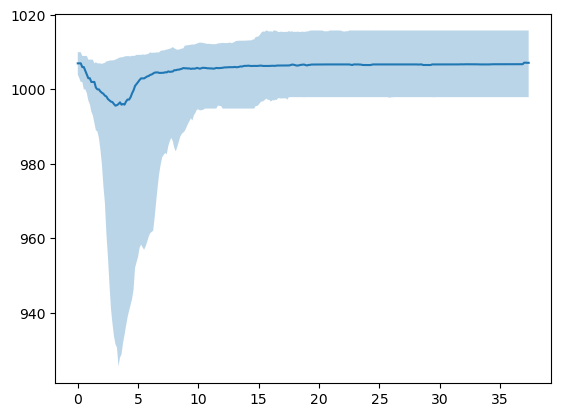

In [98]:
plt.plot(np.arange(RUNTO)/8,median_profile[:,1])
plt.fill_between(np.arange(RUNTO)/8,tenth_percentile[:,1],nintith_percentile[:,1],alpha=0.3)

### Average accuracy as a function of number of timepoints

In [108]:
from sklearn.metrics import mean_squared_error
timepoints = [1,3,5,10,15,30,50]
rf_timepoints = []
for n_time in timepoints: 
    rf_t = RandomForestRegressor(n_jobs=-1)
    x_train_ts,y_train_ts = make_X_y(ds,train_storms,n_time)
    x_valid_ts,y_valid_ts = make_X_y(ds,valid_storms,n_time)
    rf_t.fit(x_train_ts.reshape((-1,n_time*4)),y_train_ts)
    y_pred_ts = rf_t.predict(x_valid_ts.reshape((-1,n_time*4)))

    print(f"N:{n_time}\n{mean_squared_error(y_valid_ts,y_pred_ts,multioutput='raw_values',squared=False)}")
    rf_timepoints.append(rf_t)

N:1
[5.61790485 4.28089817 1.59883274 1.44267495]
N:3
[4.97729648 3.9332831  1.71269675 1.60066836]
N:5
[5.02312217 4.03003744 1.79379678 1.73298354]
N:10
[5.20939625 4.28478685 1.92997014 1.97654491]
N:15
[5.37030074 4.51915799 1.98889873 2.1117697 ]
N:30
[5.82371919 4.85114167 2.3346198  2.65657202]
N:50
[6.39666779 5.5477036  3.14340822 3.56493821]


### Peak SSHS classification accuracy 